In [2]:
# -*- coding: utf-8 -*-

In [82]:
import re
import os
import sys
import pandas as pd
import statsmodels.formula.api as smf
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import json
from scipy import stats
import csv
import pprint
from collections import defaultdict
import time
import datetime
import math
# import matplotlib.pyplot as plt; plt.rcdefaults()
# from IPython.display import Markdown, display

In [83]:
TIME_CHUNK_IN_DAYS = 10
QUARANTINE_DATE = "28/09/2018"
quarDataUnix = time.mktime(datetime.datetime.strptime(QUARANTINE_DATE, "%d/%m/%Y").timetuple())

def getTimeChunkIndex(timeStamp):
    timeStamp = float(timeStamp)
    timeDiff = timeStamp - quarDataUnix
    timeDiffDays = float(timeDiff)/(24*60*60) 
    chunkIndex = math.floor(timeDiffDays/TIME_CHUNK_IN_DAYS)
    return int(chunkIndex)

In [140]:
###load files and preprocess dataframes
ALL_COMMENTS_FILE = "/mnt/storage/quarantine/data/TheRedPill-comments.csv"
ALL_SUBMISSIONS_FILE = "/mnt/storage/quarantine/data/TheRedPill-submissions.csv"
PRE_QUARANTINE_USERS_FILE = "/mnt/storage/quarantine/data/preQuarantineUsers.csv"
TOXICITY_COMMENTS_FILE = "/mnt/storage/quarantine/data/TheRedPill-comments-toxicity.csv"
TOXICITY_SUBMISSIONS_FILE = "/mnt/storage/quarantine/data/TheRedPill-submissions-toxicity.csv"

comments_data = pd.read_csv(ALL_COMMENTS_FILE)
submissions_data = pd.read_csv(ALL_SUBMISSIONS_FILE)
toxicity_comments_data = pd.read_csv(TOXICITY_COMMENTS_FILE)
toxicity_submissions_data = pd.read_csv(TOXICITY_SUBMISSIONS_FILE)

/nethome/eshwar3/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3049: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [85]:
data = pd.concat([comments_data, submissions_data], ignore_index=True)
data['title'] = data['title'].fillna("EMPTY")
data['body'] = data['body'].fillna("EMPTY")

comments_data.shape[0] + submissions_data.shape[0], data.shape[0]

/nethome/eshwar3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """Entry point for launching an IPython kernel.


(243758, 243758)

In [86]:
# data = pd.read_csv("/mnt/storage/quarantine/data/theRedPillComments-toxicity.csv")
data['post_treatment'] = data['created_utc'] > quarDataUnix
data['time'] = data['created_utc'].apply(getTimeChunkIndex)
# data = data[data.toxicity != -1]

# ITS for Toxicity scores

In [141]:
#filter out comments with toxicity score == -1.0 since they were not scored by API
toxicity_data = toxicity_comments_data[toxicity_comments_data.toxicity >= 0]
toxicity_data = toxicity_data[toxicity_data.body != "[removed]"]

toxicity_data['post_treatment'] = toxicity_data['created_utc'] > quarDataUnix
toxicity_data['time'] = toxicity_data['created_utc'].apply(getTimeChunkIndex)

model = smf.ols('toxicity ~ time + post_treatment',data = toxicity_data)
results = model.fit()

In [142]:
print(results.summary2())

                   Results: Ordinary least squares
Model:               OLS               Adj. R-squared:      0.000     
Dependent Variable:  toxicity          AIC:                 82048.6667
Date:                2019-07-29 14:17  BIC:                 82079.3507
No. Observations:    204431            Log-Likelihood:      -41021.   
Df Model:            2                 F-statistic:         6.382     
Df Residuals:        204428            Prob (F-statistic):  0.00169   
R-squared:           0.000             Scale:               0.087463  
----------------------------------------------------------------------
                        Coef.  Std.Err.    t     P>|t|   [0.025 0.975]
----------------------------------------------------------------------
Intercept               0.3492   0.0015 234.2765 0.0000  0.3463 0.3521
post_treatment[T.True] -0.0005   0.0028  -0.1894 0.8498 -0.0060 0.0050
time                    0.0002   0.0001   1.9526 0.0509 -0.0000 0.0005
--------------------------

In [143]:
# fitted values
# data['fit'] = np.exp(results.fittedvalues)
toxicity_data['fit'] = results.fittedvalues

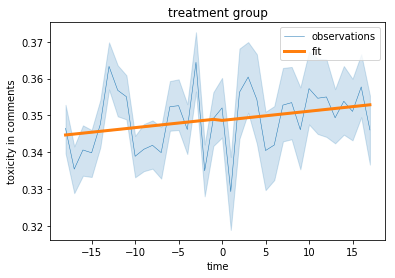

In [144]:
ax = sns.lineplot(data=toxicity_data,x='time',y='toxicity',linewidth=0.5)
ax = sns.lineplot(data=toxicity_data,x='time',y='fit', ax = ax, linewidth=3)
ax.set_title('treatment group')
plt.legend(['observations','fit'])
ax.set_ylabel('toxicity in comments');

                  Results: Ordinary least squares
Model:               OLS               Adj. R-squared:      0.002   
Dependent Variable:  toxicity          AIC:                 471.3610
Date:                2019-07-29 14:18  BIC:                 493.2337
No. Observations:    10839             Log-Likelihood:      -232.68 
Df Model:            2                 F-statistic:         9.988   
Df Residuals:        10836             Prob (F-statistic):  4.64e-05
R-squared:           0.002             Scale:               0.061135
--------------------------------------------------------------------
                       Coef.  Std.Err.    t    P>|t|   [0.025 0.975]
--------------------------------------------------------------------
Intercept              0.2238   0.0052 42.8112 0.0000  0.2136 0.2340
post_treatment[T.True] 0.0001   0.0098  0.0145 0.9884 -0.0191 0.0194
time                   0.0011   0.0005  2.3483 0.0189  0.0002 0.0020
-----------------------------------------------------

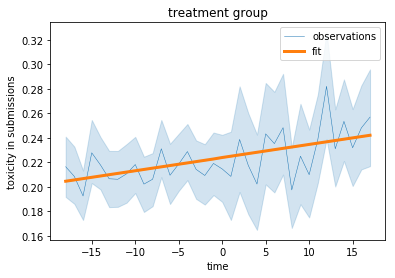

In [147]:
# run toxicity score analysis for submissions
#filter out comments with toxicity score == -1.0 since they were not scored by API
toxicity_data = toxicity_submissions_data[toxicity_submissions_data.toxicity >= 0]
toxicity_data = toxicity_data[toxicity_data.title != "[removed]"]

toxicity_data['post_treatment'] = toxicity_data['created_utc'] > quarDataUnix
toxicity_data['time'] = toxicity_data['created_utc'].apply(getTimeChunkIndex)

model = smf.ols('toxicity ~ time + post_treatment',data = toxicity_data)
results = model.fit()

print(results.summary2())

# fitted values
# data['fit'] = np.exp(results.fittedvalues)
toxicity_data['fit'] = results.fittedvalues

ax = sns.lineplot(data=toxicity_data,x='time',y='toxicity',linewidth=0.5)
ax = sns.lineplot(data=toxicity_data,x='time',y='fit', ax = ax, linewidth=3)
ax.set_title('treatment group')
plt.legend(['observations','fit'])
ax.set_ylabel('toxicity in submissions');

# ITS for posting volume and removal rates

In [113]:
# data = pd.read_csv("/mnt/storage/quarantine/data/theRedPillComments-toxicity.csv")

TrpRemovalCount = {}
TotalNumberComments = {}

for i, row in data.iterrows():
        body = row['body']
        selftext = row['selftext']
        postTime = row['created_utc']
        timeChunkIndex = getTimeChunkIndex(postTime)
        
        if timeChunkIndex in TotalNumberComments:
            TotalNumberComments[timeChunkIndex] += 1
        else:
            TotalNumberComments[timeChunkIndex] = 1
        
        ###count #removed
        if ((body == "[removed]") | (selftext == "[removed]")):
            if timeChunkIndex in TrpRemovalCount:
                TrpRemovalCount[timeChunkIndex] += 1
            else:
                TrpRemovalCount[timeChunkIndex] = 1

##get the removal rate: i.e., #removed comments normalized by #total comments
TrpRemovalRate = {}
for k in TrpRemovalCount:
    if TotalNumberComments[k] == 0:
        TrpRemovalRate[k] = 0
    else:      
        TrpRemovalRate[k] = float(TrpRemovalCount[k])/(TotalNumberComments[k])

Optimization terminated successfully.
         Current function value: 114.025854
         Iterations 5
                            Results: Poisson
Model:                  Poisson            Pseudo R-squared:   0.813    
Dependent Variable:     counts             AIC:                8215.8615
Date:                   2019-07-29 02:20   BIC:                8220.6121
No. Observations:       36                 Log-Likelihood:     -4104.9  
Df Model:               2                  LL-Null:            -21952.  
Df Residuals:           33                 LLR p-value:        0.0000   
Converged:              1.0000             Scale:              1.0000   
No. Iterations:         5.0000                                          
------------------------------------------------------------------------
                        Coef.  Std.Err.     z     P>|z|   [0.025  0.975]
------------------------------------------------------------------------
Intercept               9.1128   0.0045 2040.606

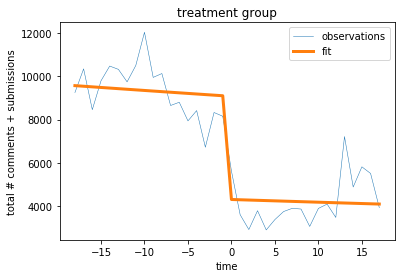

In [114]:
# posting volume
TotalNumberComments_df = pd.DataFrame()
TotalNumberComments_df['time'] = TotalNumberComments.keys()
TotalNumberComments_df['counts'] = TotalNumberComments.values()
TotalNumberComments_df['post_treatment'] = TotalNumberComments_df['time'] >= 0

# ITS
model = smf.poisson('counts ~ time + post_treatment',data = TotalNumberComments_df)
results = model.fit()

print(results.summary2())

# fitted values
TotalNumberComments_df['fit'] = np.exp(results.fittedvalues)
ax = sns.lineplot(data=TotalNumberComments_df,x='time',y='counts',linewidth=0.5)
ax = sns.lineplot(data=TotalNumberComments_df,x='time',y='fit', ax = ax, linewidth=3)
ax.set_title('treatment group')
plt.legend(['observations','fit'])
ax.set_ylabel('total # comments + submissions');

In [115]:
coeff = results.params[1]
"Coeff = ", coeff, "Effect = ", np.sign(coeff) * (100* (1.0 - np.exp(coeff)))

('Coeff = ', -0.7417521809005514, 'Effect = ', -52.37213423939496)

Optimization terminated successfully.
         Current function value: 17.094823
         Iterations 5
                           Results: Poisson
Model:                 Poisson            Pseudo R-squared:   0.864    
Dependent Variable:    counts             AIC:                1236.8273
Date:                  2019-07-29 02:20   BIC:                1241.5778
No. Observations:      36                 Log-Likelihood:     -615.41  
Df Model:              2                  LL-Null:            -4512.6  
Df Residuals:          33                 LLR p-value:        0.0000   
Converged:             1.0000             Scale:              1.0000   
No. Iterations:        5.0000                                          
-----------------------------------------------------------------------
                        Coef.  Std.Err.    z     P>|z|   [0.025  0.975]
-----------------------------------------------------------------------
Intercept               7.2482   0.0115 628.0364 0.0000  7.22

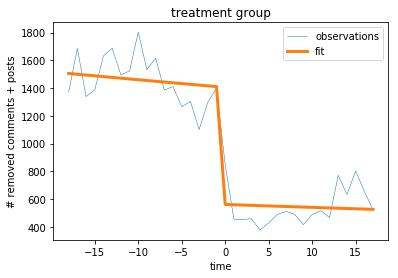

In [116]:
# # comments removed
TrpRemovalCount_df = pd.DataFrame()
TrpRemovalCount_df['time'] = TrpRemovalCount.keys()
TrpRemovalCount_df['counts'] = TrpRemovalCount.values()
TrpRemovalCount_df['post_treatment'] = TrpRemovalCount_df['time'] >= 0

# ITS
model = smf.poisson('counts ~ time + post_treatment',data = TrpRemovalCount_df)
results = model.fit()

print(results.summary2())

# fitted values
TrpRemovalCount_df['fit'] = np.exp(results.fittedvalues)
ax = sns.lineplot(data=TrpRemovalCount_df,x='time',y='counts',linewidth=0.5)
ax = sns.lineplot(data=TrpRemovalCount_df,x='time',y='fit', ax = ax, linewidth=3)
ax.set_title('treatment group')
plt.legend(['observations','fit'])
ax.set_ylabel('# removed comments + posts');

In [117]:
coeff = results.params[1]
"Effect = ", np.sign(coeff) * np.ceil(100* (1.0 - np.exp(coeff)))

('Effect = ', -60.0)

                   Results: Ordinary least squares
Model:               OLS               Adj. R-squared:      0.671     
Dependent Variable:  counts            AIC:                 -231.8089 
Date:                2019-07-29 02:20  BIC:                 -227.0584 
No. Observations:    36                Log-Likelihood:      118.90    
Df Model:            2                 F-statistic:         36.67     
Df Residuals:        33                Prob (F-statistic):  4.12e-09  
R-squared:           0.690             Scale:               8.6387e-05
----------------------------------------------------------------------
                        Coef.  Std.Err.    t    P>|t|   [0.025  0.975]
----------------------------------------------------------------------
Intercept               0.1560   0.0036 43.5403 0.0000  0.1488  0.1633
post_treatment[T.True] -0.0253   0.0062 -4.0855 0.0003 -0.0380 -0.0127
time                   -0.0001   0.0003 -0.2192 0.8278 -0.0007  0.0005
--------------------------

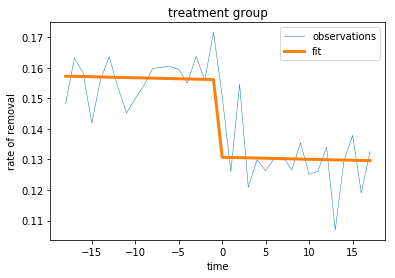

In [118]:
# # comments removed
TrpRemovalRate_df = pd.DataFrame()
TrpRemovalRate_df['time'] = TrpRemovalRate.keys()
TrpRemovalRate_df['counts'] = TrpRemovalRate.values()
TrpRemovalRate_df['post_treatment'] = TrpRemovalRate_df['time'] >= 0

# ITS
model = smf.ols('counts ~ time + post_treatment',data = TrpRemovalRate_df)
results = model.fit()

print(results.summary2())

# fitted values
TrpRemovalRate_df['fit'] = (results.fittedvalues)
# TrpRemovalRate_df['fit'] = np.exp(results.fittedvalues)
ax = sns.lineplot(data=TrpRemovalRate_df,x='time',y='counts',linewidth=0.5)
ax = sns.lineplot(data=TrpRemovalRate_df,x='time',y='fit', ax = ax, linewidth=3)
ax.set_title('treatment group')
plt.legend(['observations','fit'])
ax.set_ylabel('rate of removal');

In [119]:
coeff = results.params[1]
"Coefficient = ", coeff,"Effect = ", np.ceil(100* coeff), "%"

('Coefficient = ', -0.025344383144142196, 'Effect = ', -2.0, '%')

In [163]:
#removal of submissions
"Total #submissions", submissions_data.shape[0], "Title=[removed]", submissions_data[submissions_data.title == "[removed]"].shape[0], "Selftext=[removed]", submissions_data[submissions_data.selftext == "[removed]"].shape[0], submissions_data[submissions_data.title == "[removed]"].shape[0], "Selftext=[removed]"

('Total #submissions',
 10899,
 'Title=[removed]',
 0,
 'Selftext=[removed]',
 8054,
 0,
 'Selftext=[removed]')

In [164]:
submissions_data[(submissions_data.selftext == "[removed]") & (submissions_data.is_self == True)].shape[0]

8054

# Influx of new users

In [105]:
RED_PILL_COMMENTS_FILE = "/mnt/storage/quarantine/data/theRedPillComments.csv"
RED_PILL_SUBMISSIONS_FILE = "/mnt/storage/quarantine/data/theRedPillSubmissions.csv"

authorsInEachChunk = defaultdict(set)

with open(RED_PILL_COMMENTS_FILE) as csvfile:
    readCSV = csv.DictReader(csvfile)
    for row in readCSV:
        author = row['author']
        if (author != "[deleted]"):
            postTime = row['created_utc']
            timeChunkIndex = getTimeChunkIndex(postTime)
            authorsInEachChunk[timeChunkIndex].add(author) 

with open(RED_PILL_SUBMISSIONS_FILE) as csvfile:
    readCSV = csv.DictReader(csvfile)
    for row in readCSV:
        author = row['author']
        if (author != "[deleted]"):
            postTime = row['created_utc']
            timeChunkIndex = getTimeChunkIndex(postTime)
            authorsInEachChunk[timeChunkIndex].add(author) 

In [106]:
lists = sorted(authorsInEachChunk.items())

In [107]:
seenUsersSet = set()
for ulist in lists[0:3]:
    chunkUsers = ulist[1]
    seenUsersSet = seenUsersSet.union(chunkUsers)

In [108]:
newsUsersCount = defaultdict(int)
for ulist in lists[4:]:
    chunkIndex = ulist[0]
    chunkUsers = ulist[1]
    newUsersSet = chunkUsers.difference(seenUsersSet)
    newsUsersCount[chunkIndex] = len(newUsersSet)
    seenUsersSet = seenUsersSet.union(chunkUsers)

Optimization terminated successfully.
         Current function value: 13.103006
         Iterations 6
                           Results: Poisson
Model:                  Poisson            Pseudo R-squared:   0.891   
Dependent Variable:     counts             AIC:                844.5924
Date:                   2019-07-29 02:18   BIC:                848.9896
No. Observations:       32                 Log-Likelihood:     -419.30 
Df Model:               2                  LL-Null:            -3851.1 
Df Residuals:           29                 LLR p-value:        0.0000  
Converged:              1.0000             Scale:              1.0000  
No. Iterations:         6.0000                                         
-----------------------------------------------------------------------
                        Coef.  Std.Err.    z     P>|z|   [0.025  0.975]
-----------------------------------------------------------------------
Intercept               6.5922   0.0163 403.3844 0.0000  6.56

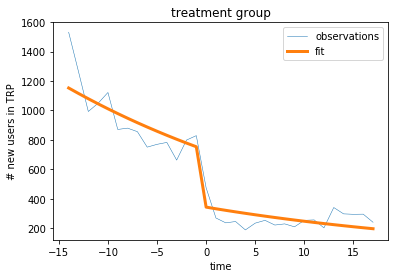

In [109]:
# # comments removed
TrpNewUsersCount_df = pd.DataFrame()
TrpNewUsersCount_df['time'] = newsUsersCount.keys()
TrpNewUsersCount_df['counts'] = newsUsersCount.values()
TrpNewUsersCount_df['post_treatment'] = TrpNewUsersCount_df['time'] >= 0

# ITS
model = smf.poisson('counts ~ time + post_treatment',data = TrpNewUsersCount_df)
results = model.fit()

print(results.summary2())
ri
# fitted values
TrpNewUsersCount_df['fit'] = np.exp(results.fittedvalues)
ax = sns.lineplot(data=TrpNewUsersCount_df,x='time',y='counts',linewidth=0.5)
ax = sns.lineplot(data=TrpNewUsersCount_df,x='time',y='fit', ax = ax, linewidth=3)
ax.set_title('treatment group')
plt.legend(['observations','fit'])
ax.set_ylabel('# new users in TRP');

### The treatment reduced the number of newcomers on TRP by e^-0.7526 = 53%

In [112]:
coeff = results.params[1]
"Coeff = ", coeff, "Effect = ", np.sign(coeff) * (100* (1.0 - np.exp(coeff)))

('Coeff = ', -0.7525715528649313, 'Effect = ', -52.884660230627766)

# Toxicity levels of "newcomers" within chunks